# **Práctica 3 : Análisis de Señales ECG**



*   Federico Ocampo Quiceno
*   Daniel Palacio Alvarez
*   Alejandro Agudelo Tamayo



In [ ]:
import numpy as np
import scipy.io as sio
from scipy.signal import find_peaks
import scipy.stats as st
from scipy.stats import kstest, norm, levene, ttest_ind, mannwhitneyu
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Carga el archivo .mat desde Google Drive que contiene las señales ECG
data = sio.loadmat('/content/drive/MyDrive/Bioseñales/signals.mat')

# Muestra las claves (nombres de variables) almacenadas en el archivo
print(data.keys())

# Extrae y aplana la señal ECG ya filtrada
ecg_filtrada = data['ECG_filtered'].flatten()

# Extrae y aplana la señal ECG cruda (sin procesar)
ecg_cruda = data['ECG_asRecording'].flatten()

# Muestra la dimensión de la señal ECG filtrada
print('\n', ecg_filtrada.shape)

dict_keys(['__header__', '__version__', '__globals__', 'Fs', 'ECG_asRecording', 'ECG_filtered', 'EMG_filtered1', 'EMG_filtered2', 'EMG_asRecording1', 'EMG_asRecording2'])

 (30720,)


La función RMS permite calcular el valor cuadrático medio de una señal y se define en forma discreta con N número de muestras como:

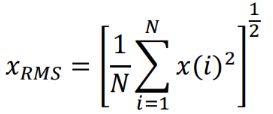


Creación de la función RMS:

In [ ]:
# Función para calcular el valor RMS (Root Mean Square) de una señal
def calcular_rms(signal):
    N = len(signal)  # Número total de muestras en la señal
    valor_rms = np.sqrt(np.sum(signal**2) / N)  # Fórmula del RMS
    return valor_rms  # Retorna el valor RMS

Se crea el vector de tiempo para ambas señales:

In [ ]:
# Definición de la frecuencia de muestreo (Hz)
Fs = 1024

# Cálculo del periodo de muestreo (inverso de la frecuencia)
T = 1 / Fs

# Número total de muestras en la señal ECG cruda
muestras = ecg_cruda.size

# Crea un vector de tiempo desde 0 hasta la duración total, con paso igual al periodo de muestreo
t = np.arange(0, muestras * T, T)

# Imprime el vector de tiempo
print(t)

[0.00000000e+00 9.76562500e-04 1.95312500e-03 ... 2.99970703e+01
 2.99980469e+01 2.99990234e+01]


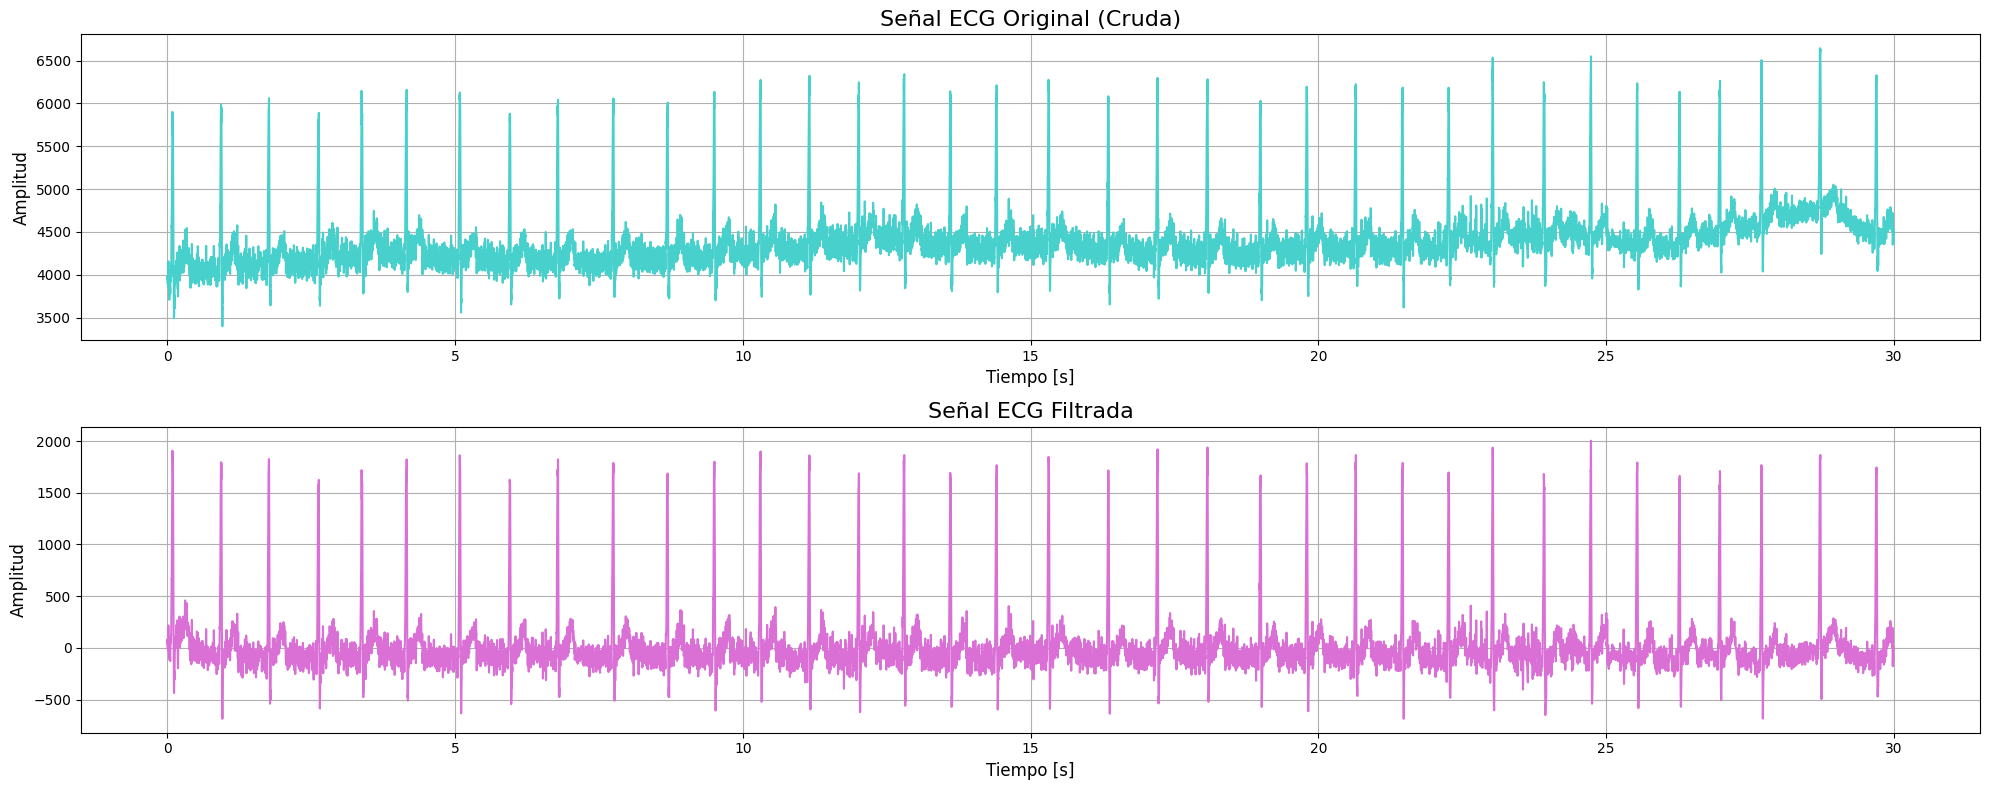

In [ ]:
# Crea una figura grande para visualizar las señales ECG cruda y filtrada
plt.figure(figsize=(20, 8))  # Tamaño amplio para mayor claridad

# Subplot 1: Señal ECG original (cruda)
plt.subplot(2, 1, 1)
plt.plot(t, ecg_cruda, color='mediumturquoise')  # Mantiene el color original
plt.title('Señal ECG Original (Cruda)', fontsize=16)
plt.xlabel('Tiempo [s]', fontsize=12)
plt.ylabel('Amplitud', fontsize=12)
plt.grid(True)  # Agrega rejilla para facilitar la lectura

# Subplot 2: Señal ECG filtrada
plt.subplot(2, 1, 2)
plt.plot(t, ecg_filtrada, color='orchid')  # Mantiene el color original
plt.title('Señal ECG Filtrada', fontsize=16)
plt.xlabel('Tiempo [s]', fontsize=12)
plt.ylabel('Amplitud', fontsize=12)
plt.grid(True)

# Ajuste automático del diseño para que no se encimen los elementos
plt.tight_layout()

# Guarda la figura en formato PNG con buena resolución
plt.savefig('ECG_cruda_vs_filtrada.png', dpi=300)

# Muestra la gráfica en pantalla
plt.show()

Graficación de un ciclo cardiaco de la señal original:

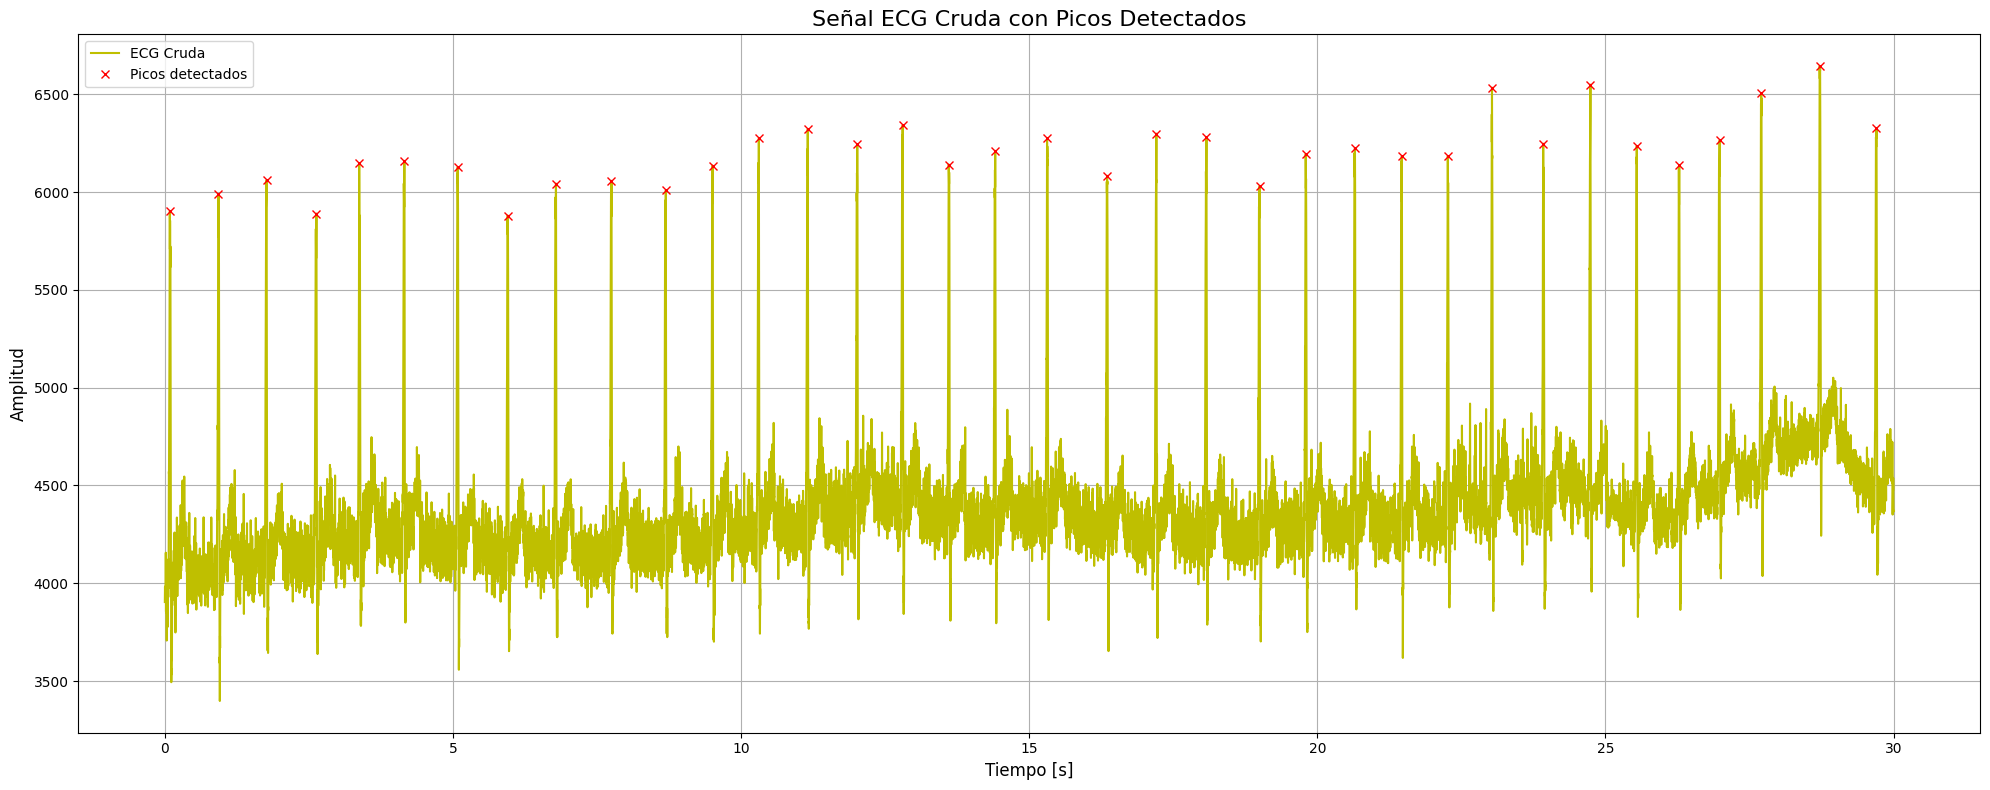

In [ ]:
# Detección de picos en la señal ECG cruda
# - 'distance=Fs/2' asegura un mínimo de 0.5 segundos entre picos (ritmo cardiaco fisiológico)
# - 'height=5500' filtra solo los picos que superen ese umbral de amplitud
peaks, _ = find_peaks(ecg_cruda, distance=Fs/2, height=5500)

# Crear figura para graficar la señal con los picos detectados
plt.figure(figsize=(20, 8))

# Graficar la señal ECG cruda
plt.plot(t, ecg_cruda, label='ECG Cruda', color='y')  # 'y' = yellow

# Graficar los picos detectados como cruces rojas
plt.plot(t[peaks], ecg_cruda[peaks], 'rx', label='Picos detectados')

# Título y etiquetas con mejor visibilidad
plt.title('Señal ECG Cruda con Picos Detectados', fontsize=16)
plt.xlabel('Tiempo [s]', fontsize=12)
plt.ylabel('Amplitud', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Guardar la gráfica como imagen PNG
plt.savefig('ECG_picos_detectados.png', dpi=300)

# Mostrar la gráfica en pantalla
plt.show()

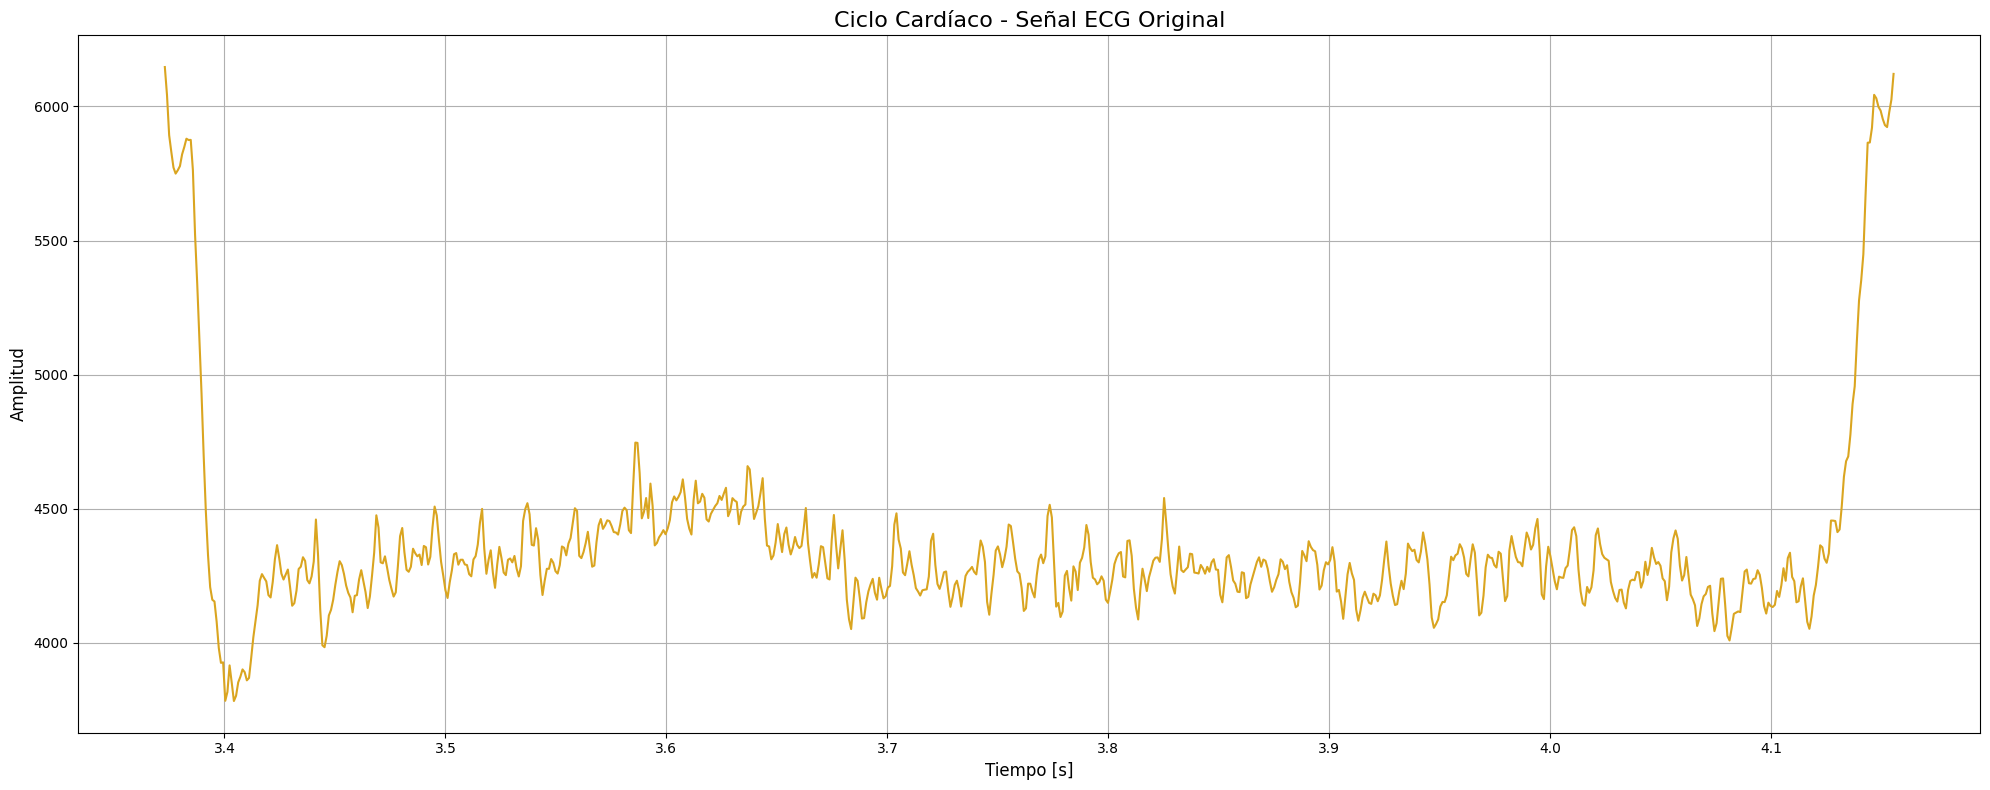

In [ ]:
# Extrae el intervalo de tiempo correspondiente a un ciclo cardíaco (entre el 5to y 6to pico)
t_ciclo = t[peaks[4]:peaks[5]]

# Extrae los valores de amplitud de la señal cruda en ese mismo intervalo
ciclo_cruda = ecg_cruda[peaks[4]:peaks[5]]

# Crea figura para graficar el ciclo cardíaco
plt.figure(figsize=(20, 8))

# Graficar el segmento de la señal correspondiente a un ciclo cardíaco
plt.plot(t_ciclo, ciclo_cruda, color='goldenrod')

# Título y etiquetas con mejor estética
plt.title('Ciclo Cardíaco - Señal ECG Original', fontsize=16)
plt.xlabel('Tiempo [s]', fontsize=12)
plt.ylabel('Amplitud', fontsize=12)
plt.grid(True)
plt.tight_layout()

# Guarda la gráfica como imagen PNG
plt.savefig('ECG_ciclo_crudo.png', dpi=300)

# Muestra la gráfica en pantalla
plt.show()


Estadísticas:

In [ ]:
# --- Análisis estadístico del ciclo cardíaco de la señal original (ECG cruda) ---

# Calcular el valor promedio del ciclo
promedio_crudo = np.mean(ciclo_cruda)
print("El promedio de la señal original es: ", promedio_crudo)

# Calcular el valor RMS usando la función definida anteriormente
RMS_cruda = calcular_rms(ciclo_cruda)
print("El RMS de la señal original es: ", RMS_cruda)

# Calcular la varianza (medida de dispersión respecto al promedio)
varianza_cruda = np.var(ciclo_cruda)
print("La varianza de la señal original es: ", varianza_cruda)

# Calcular la desviación estándar (raíz cuadrada de la varianza)
desviacion_estandar_cruda = np.std(ciclo_cruda)
print("La desviación estándar de la señal original es: ", desviacion_estandar_cruda)



El promedio de la señal original es:  4352.683223581671
El RMS de la señal original es:  4365.992169494949
La varianza de la señal original es:  116036.3792418872
La desviación estándar de la señal original es:  340.6411296979377


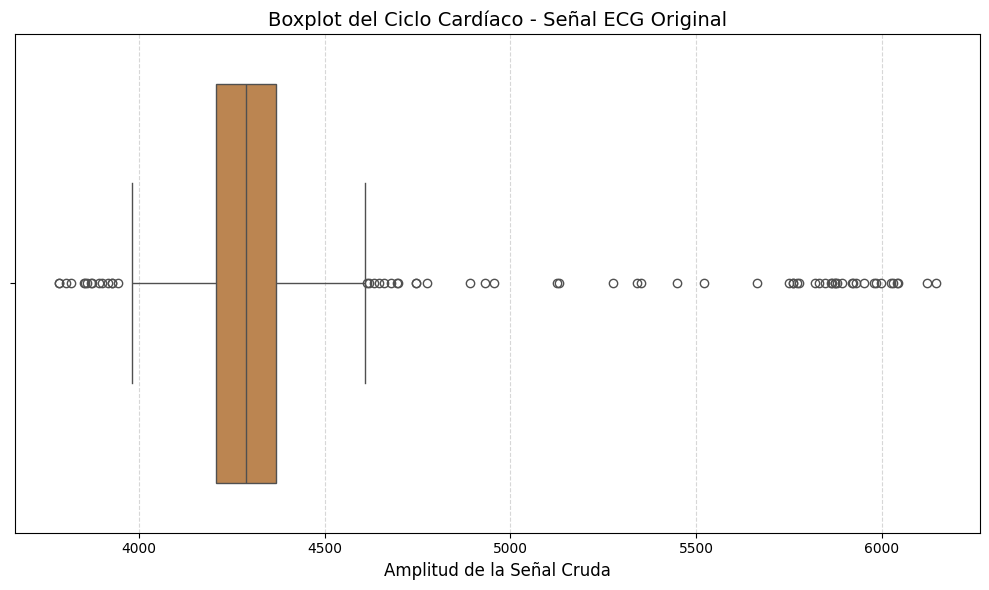

In [ ]:
# Crear un boxplot del ciclo cardíaco de la señal ECG cruda
plt.figure(figsize=(10, 6))

# Gráfico de caja usando seaborn (color original: 'peru')
sns.boxplot(x=ciclo_cruda, color='peru')

# Título y etiquetas mejoradas
plt.title('Boxplot del Ciclo Cardíaco - Señal ECG Original', fontsize=14)
plt.xlabel('Amplitud de la Señal Cruda', fontsize=12)
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()

# Guardar la figura como imagen PNG
plt.savefig('ECG_boxplot_crudo.png', dpi=300)

# Mostrar la gráfica en pantalla
plt.show()

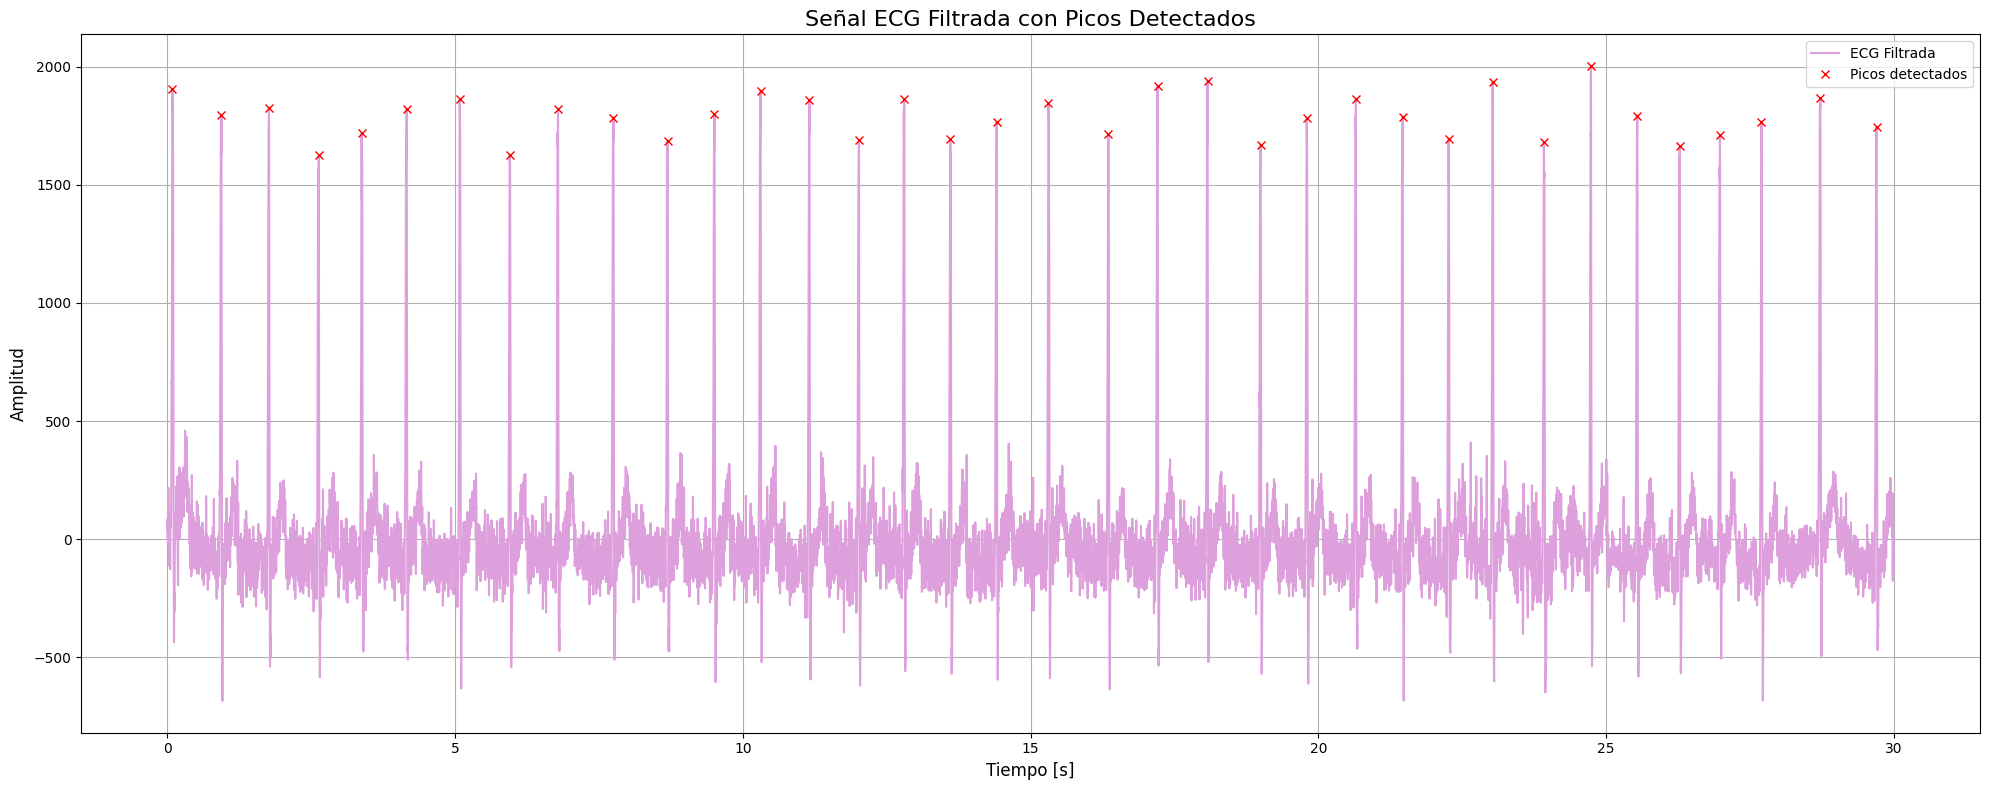

In [ ]:
# Detección de picos en la señal ECG filtrada
# - 'distance=Fs/2' asegura un mínimo de 0.5 segundos entre picos (ritmo cardiaco fisiológico)
# - 'height=1000' filtra solo los picos que superen ese umbral de amplitud
peaks, _ = find_peaks(ecg_filtrada, distance=Fs/2, height=1000)

# Crear una figura para graficar la señal filtrada y los picos detectados
plt.figure(figsize=(20, 8))

# Graficar la señal ECG filtrada
plt.plot(t, ecg_filtrada, label='ECG Filtrada', color='plum')  # 'plum' = color suave

# Graficar los picos detectados como cruces rojas
plt.plot(t[peaks], ecg_filtrada[peaks], 'rx', label='Picos detectados')

# Título y etiquetas con mejor visibilidad
plt.title('Señal ECG Filtrada con Picos Detectados', fontsize=16)
plt.xlabel('Tiempo [s]', fontsize=12)
plt.ylabel('Amplitud', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Guarda la gráfica como imagen PNG
plt.savefig('ECG_filtrada_picos_detectados.png', dpi=300)

# Muestra la gráfica en pantalla
plt.show()


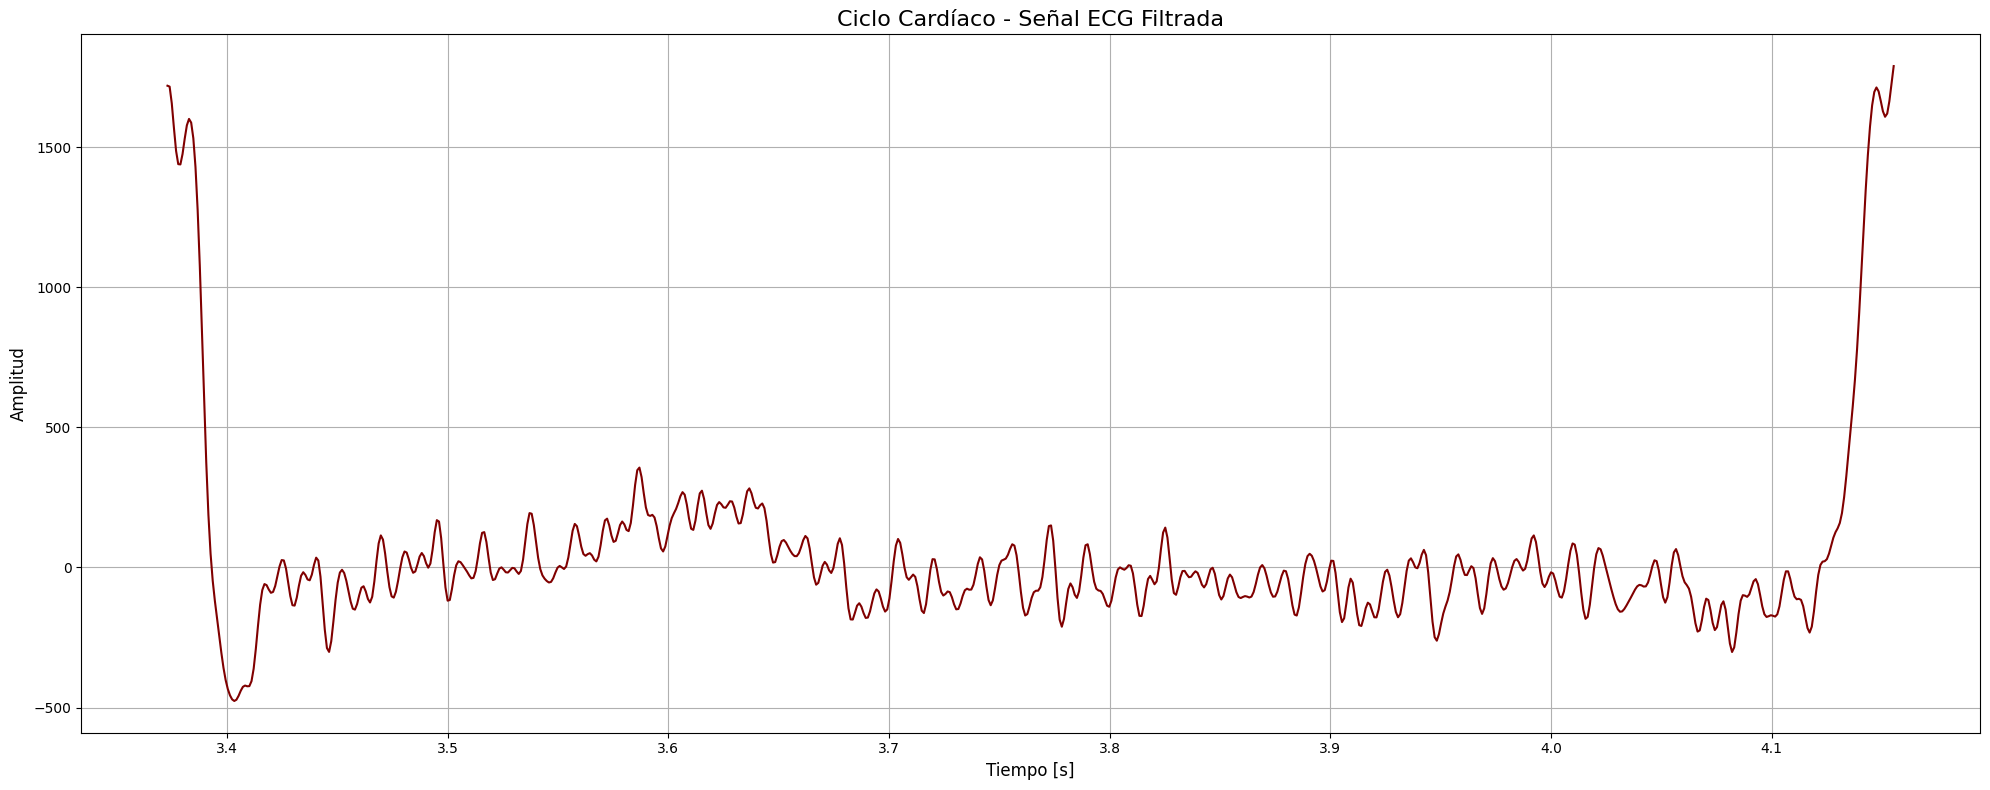

In [ ]:
# Extrae el intervalo de tiempo correspondiente a un ciclo cardíaco (entre el 5to y 6to pico) en la señal filtrada
t_ciclo = t[peaks[4]:peaks[5]]

# Extrae los valores de amplitud de la señal filtrada en ese mismo intervalo
ciclo_filtrada = ecg_filtrada[peaks[4]:peaks[5]]

# Crear figura para graficar el ciclo cardíaco de la señal filtrada
plt.figure(figsize=(20, 8))

# Graficar el segmento de la señal filtrada correspondiente a un ciclo cardíaco
plt.plot(t_ciclo, ciclo_filtrada, color='maroon')  # 'maroon' es un color rojo oscuro

# Título y etiquetas mejoradas
plt.title('Ciclo Cardíaco - Señal ECG Filtrada', fontsize=16)
plt.xlabel('Tiempo [s]', fontsize=12)
plt.ylabel('Amplitud', fontsize=12)
plt.grid(True)
plt.tight_layout()

# Guardar la figura como imagen PNG
plt.savefig('ECG_ciclo_filtrado.png', dpi=300)

# Mostrar la gráfica en pantalla
plt.show()


In [ ]:
# Calcular promedio
promedio_filtrado = np.mean(ciclo_filtrada)
print("El promedio de la señal filtrada es: ", promedio_filtrado)

# Calcular RMS
RMS_filtrada = calcular_rms(ciclo_filtrada)
print("El RMS de la señal filtrada es: ", RMS_filtrada)

# Calcular la Varianza
varianza_filtrada = np.var(ciclo_filtrada)
print("La varianza de la señal filtrada es: ", varianza_filtrada)

# Calcular Desviación estándar
desviacion_estandar_filtrada = np.std(ciclo_filtrada)
print("La desviación estándar de la señal filtrada es: ", desviacion_estandar_filtrada)


El promedio de la señal filtrada es:  40.87110478533409
El RMS de la señal filtrada es:  341.35094444116964
La varianza de la señal filtrada es:  114850.02006450474
La desviación estándar de la señal filtrada es:  338.89529365942036


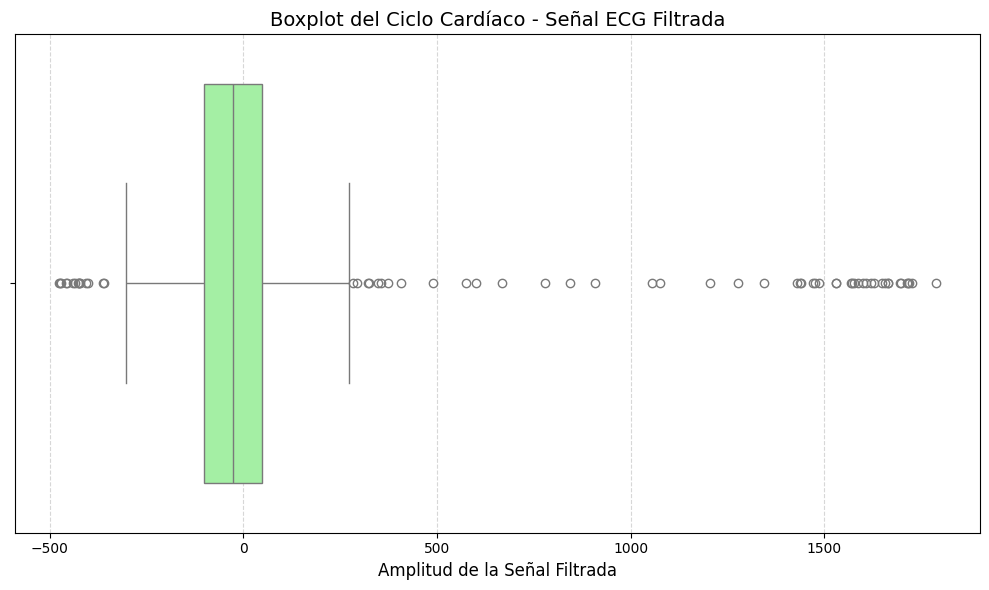

In [ ]:
# Crear un boxplot del ciclo cardíaco de la señal ECG filtrada
plt.figure(figsize=(10, 6))

# Gráfico de caja usando seaborn (color original: 'palegreen')
sns.boxplot(x=ciclo_filtrada, color='palegreen')

# Título y etiquetas mejoradas
plt.title('Boxplot del Ciclo Cardíaco - Señal ECG Filtrada', fontsize=14)
plt.xlabel('Amplitud de la Señal Filtrada', fontsize=12)
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()

# Guardar la figura como imagen PNG
plt.savefig('ECG_boxplot_filtrado.png', dpi=300)

# Mostrar la gráfica en pantalla
plt.show()

Extracción de 15 ciclos para la señal filtrada:

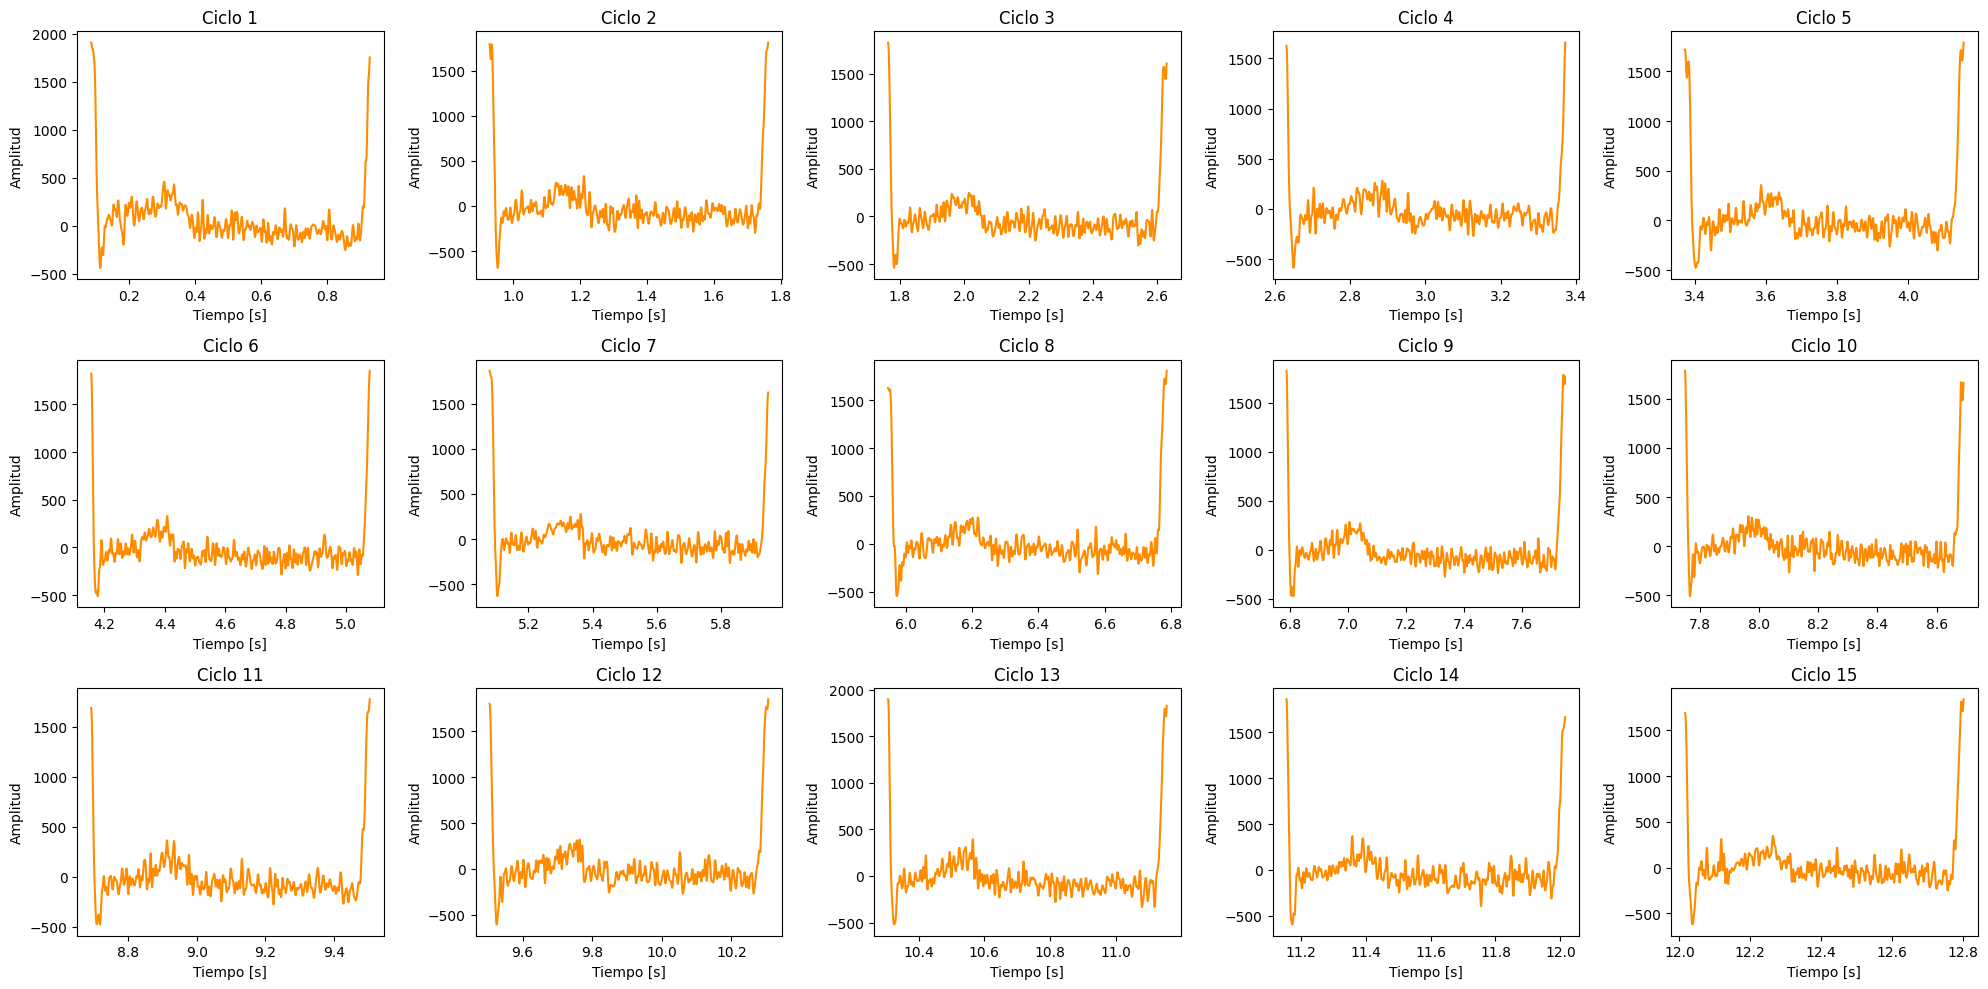

Ciclo 1: Promedio = 74.0100, Varianza = 96684.3149
Ciclo 2: Promedio = -1.4626, Varianza = 104790.4655
Ciclo 3: Promedio = -10.4330, Varianza = 82451.2511
Ciclo 4: Promedio = -20.9752, Varianza = 46839.0197
Ciclo 5: Promedio = 40.8711, Varianza = 114850.0201
Ciclo 6: Promedio = -27.9437, Varianza = 58147.5895
Ciclo 7: Promedio = 0.4308, Varianza = 77707.2812
Ciclo 8: Promedio = 21.4079, Varianza = 100268.1815
Ciclo 9: Promedio = -10.1753, Varianza = 71784.9558
Ciclo 10: Promedio = 8.8121, Varianza = 68481.0598
Ciclo 11: Promedio = -8.9062, Varianza = 76088.3849
Ciclo 12: Promedio = 13.2133, Varianza = 93862.6959
Ciclo 13: Promedio = -4.2033, Varianza = 87951.5045
Ciclo 14: Promedio = -14.9697, Varianza = 77022.1329
Ciclo 15: Promedio = 27.1083, Varianza = 89636.9356


In [ ]:
# Extracción de 15 ciclos
ciclos = []
promedios = []
varianzas = []

fig, axs = plt.subplots(3, 5, figsize=(20, 10))  # 3 filas y 5 columnas

for i in range(15):
    # Extraer el ciclo actual entre dos picos consecutivos
    ciclo_actual = ecg_filtrada[peaks[i]:peaks[i+1]]
    ciclos.append(ciclo_actual)
    # Calcular el promedio y varianza del ciclo
    promedio_ciclo = np.mean(ciclo_actual)
    promedios.append(promedio_ciclo)
    varianza_ciclo = np.var(ciclo_actual)
    varianzas.append(varianza_ciclo)

    t_ciclo = t[peaks[i]:peaks[i+1]]

    # Definir la posición en el subplot
    row = i // 5 # Cociente de la division
    col = i % 5 # Residuo de la division

    # Graficar el ciclo en la posición correspondiente
    axs[row, col].plot(t_ciclo, ciclo_actual, color='darkorange')
    axs[row, col].set_title(f'Ciclo {i+1}')
    axs[row, col].set_xlabel('Tiempo [s]')
    axs[row, col].set_ylabel('Amplitud')

# Ajustar la distribución del gráfico
plt.tight_layout()
plt.savefig('15 ciclos para la señal filtrada.png', dpi=300)
plt.show()

# Mostrar los promedios y varianzas de cada ciclo
for i in range(15):
    print(f"Ciclo {i+1}: Promedio = {promedios[i]:.4f}, Varianza = {varianzas[i]:.4f}")


## Comparación entre el ciclo 1 y ciclo 4




**Normalidad:**

Prueba de Kolmogorov-Smirnov

**Hipótesis:**

p > alpha

*   H0: Los datos parecen normales (No se puede rechazar H0)
*   H1: Los datos no parecen normales (Se rechaza H0)



In [ ]:
# Selección de dos ciclos para realizar la prueba de normalidad (ciclo 2 y ciclo 5)
ciclo_dos = ciclos[1]  # Segundo ciclo
ciclo_cinco = ciclos[4]  # Quinto ciclo

# Realizar la prueba de Kolmogorov-Smirnov para el ciclo dos
ks_stats2, p_value2 = kstest(ciclo_dos, 'norm')  # Comparar con la distribución normal estándar
print('Estadístico KS = %.3f, p-valor = %.3f' % (ks_stats2, p_value2))

# Tomar decisión en base al valor p
if p_value2 > 0.05:
    print('Los datos parecen normales (No se puede rechazar H0)')
else:
    print('Los datos no parecen normales (Se rechaza H0)')

Estadístico KS = 0.708, p-valor = 0.000
Los datos no parecen normales (Se rechaza H0)


In [ ]:
# Realizar la prueba de Kolmogorov-Smirnov para el ciclo cinco
ks_stats5, p_value5 = kstest(ciclo_cinco, 'norm')  # Comparar con la distribución normal estándar
print('Estadístico KS = %.3f, p-valor = %.3f' % (ks_stats5, p_value5))

# Tomar decisión en base al valor p
if p_value5 > 0.05:
    print('Los datos parecen normales (No se puede rechazar H0)')
else:
    print('Los datos no parecen normales (Se rechaza H0)')

Estadístico KS = 0.587, p-valor = 0.000
Los datos no parecen normales (Se rechaza H0)


**Homocedasticidad:**

Prueba de Levene

**Hipótesis:**

*   H0: Los grupos tienen varianzas iguales
*   H1: Los grupos tienen varianzas diferentes



In [ ]:
# Realizar la prueba de Levene para comparar las varianzas entre los ciclos dos y cinco
stat_levene, p_levene = levene(ciclo_dos, ciclo_cinco)
print('Estadístico Levene = %.3f, p-valor = %.3f' % (stat_levene, p_levene))

# Tomar decisión en base al p-valor
if p_levene > 0.05:
    print('Los grupos tienen varianzas iguales (No se puede rechazar H0)')
else:
    print('Los grupos tienen varianzas diferentes (Se rechaza H0)')

Estadístico Levene = 0.607, p-valor = 0.436
Los grupos tienen varianzas iguales (No se puede rechazar H0)


**Independencia**

Se asume que los grupos son independientes

**U Mann-Whitney-Wilcoxon**

* HO: No hay diferencia (en términos de tendencia central) entre los dos grupos de la población.
* H1: Existe una diferencia (con respecto a la tendencia central) entre los dos grupos de la población.

Las condiciones del u-test son:

* Los datos tienen que ser independientes.

* Los datos tienen que ser ordinales.

* No es necesario asumir que las muestras se distribuyen de forma normal.

* Igualdad de varianza entre grupos (homocedasticidad).

In [ ]:
# Realizar la prueba de Mann-Whitney U para comparar las distribuciones entre los ciclos dos y cinco
stat_mann, p_mann = mannwhitneyu(ciclo_dos, ciclo_cinco)
print('Estadístico Mann-Whitney U = %.3f, p-valor = %.0f' % (stat_mann, p_mann))

# Tomar decisión en base al p-valor
if p_mann > 0.05:
    print('No se puede rechazar H0, no hay diferencias significativas entre los ciclos.')
else:
    print('Se rechaza H0, hay diferencias significativas entre los ciclos.')

Estadístico Mann-Whitney U = 285265.000, p-valor = 0
Se rechaza H0, hay diferencias significativas entre los ciclos.


## Comparación entre el ciclo 13 y ciclo 15

**Normalidad:**

Prueba de Kolmogorov-Smirnov

**Hipótesis:**

p > alpha

*   H0: Los datos parecen normales (No se puede rechazar H0)
*   H1: Los datos no parecen normales (Se rechaza H0)


In [ ]:
# Selección del ciclo 13 para realizar la prueba de normalidad
ciclo_13 = ciclos[12]  # Ciclo 13

# Realizar la prueba de Kolmogorov-Smirnov para el ciclo 13
ks_stats13, p_value13 = kstest(ciclo_13, 'norm')  # Comparar con la distribución normal estándar
print('Estadístico KS = %.3f, p-valor = %.3f' % (ks_stats13, p_value13))

# Tomar decisión en base al p-valor
if p_value13 > 0.05:
    print('Los datos parecen normales (No se puede rechazar H0)')
else:
    print('Los datos no parecen normales (Se rechaza H0)')

Estadístico KS = 0.704, p-valor = 0.000
Los datos no parecen normales (Se rechaza H0)


In [ ]:
# Selección del ciclo 15 para realizar la prueba de normalidad
ciclo_15 = ciclos[14]  # Ciclo 15

# Realizar la prueba de Kolmogorov-Smirnov para el ciclo 15
ks_stats15, p_value15 = kstest(ciclo_15, 'norm')  # Comparar con la distribución normal estándar
print('Estadístico KS = %.3f, p-valor = %.3f' % (ks_stats15, p_value15))

# Tomar decisión en base al p-valor
if p_value15 > 0.05:
    print('Los datos parecen normales (No se puede rechazar H0)')
else:
    print('Los datos no parecen normales (Se rechaza H0)')

Estadístico KS = 0.587, p-valor = 0.000
Los datos no parecen normales (Se rechaza H0)


**Homocedasticidad:**

Prueba de Levene

**Hipótesis:**

*   H0: Los grupos tienen varianzas iguales
*   H1: Los grupos tienen varianzas diferentes

In [ ]:
# Realizar la prueba de Levene para comparar las varianzas entre los ciclos 13 y 15
stat_levene, p_levene = levene(ciclo_13, ciclo_15)
print('Estadístico Levene = %.3f, p-valor = %.3f' % (stat_levene, p_levene))

# Tomar decisión en base al p-valor
if p_levene > 0.05:
    print('Los grupos tienen varianzas iguales (No se puede rechazar H0)')
else:
    print('Los grupos tienen varianzas diferentes (Se rechaza H0)')

Estadístico Levene = 0.198, p-valor = 0.656
Los grupos tienen varianzas iguales (No se puede rechazar H0)


**Independencia**

Se asume que los grupos son independientes

**U Mann-Whitney-Wilcoxon**

* HO: No hay diferencia (en términos de tendencia central) entre los dos grupos de la población.
* H1: Existe una diferencia (con respecto a la tendencia central) entre los dos grupos de la población.

Las condiciones del u-test son:

* Los datos tienen que ser independientes.

* Los datos tienen que ser ordinales.

* No es necesario asumir que las muestras se distribuyen de forma normal.

* Igualdad de varianza entre grupos (homocedasticidad).


In [ ]:
# Realizar la prueba de Mann-Whitney U para comparar las distribuciones entre los ciclos 13 y 15
stat_mann, p_mann = mannwhitneyu(ciclo_13, ciclo_15)
print('Estadístico Mann-Whitney U = %.3f, p-valor = %.3f' % (stat_mann, p_mann))

# Tomar decisión en base al p-valor
if p_mann > 0.05:
    print('No se puede rechazar H0, no hay diferencias significativas entre los ciclos.')
else:
    print('Se rechaza H0, hay diferencias significativas entre los ciclos.')

Estadístico Mann-Whitney U = 293838.000, p-valor = 0.000
Se rechaza H0, hay diferencias significativas entre los ciclos.


**Estacionariedad**

Prueba de Dickey-Fuller [5]

* HO: La serie temporal no es estacionaria, es decir, tiene una estructura que depende del tiempo y no presenta una varianza constante a lo largo del tiempo.

* H1: La serie temporal es estacionaria.

Estadístico ADF: Es el valor que indica qué tan lejos está la serie de ser estacionaria (valores más negativos indican estacionariedad).

Valores críticos: Estos son los valores del estadístico ADF que debes comparar para niveles de significancia del 1%, 5%, y 10%.

In [ ]:
# Aplicar la prueba de Dickey-Fuller aumentada a la señal ECG filtrada
result = adfuller(ecg_filtrada)

# Mostrar el estadístico ADF, p-valor y los valores críticos
print('Estadístico ADF: %f' % result[0])
print('p-valor: %f' % result[1])
print('Valores Críticos:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Decisión en base al p-valor
if result[1] <= 0.05:
    print("La serie temporal es estacionaria.")
else:
    print("La serie temporal no es estacionaria.")


Estadístico ADF: -24.134107
p-valor: 0.000000
Valores Críticos:
	1%: -3.431
	5%: -2.862
	10%: -2.567
La serie temporal es estacionaria.


In [ ]:
directorio_actual=os.getcwd()
print(directorio_actual)

/content


In [ ]:
archivos=os.listdir(directorio_actual + "/drive/MyDrive/Bioseñales/datos_senales_datos_parkinson_cursos/control")
print(len(archivos))

36


In [ ]:
#ruta de un archivo
path_subjecti=(directorio_actual + "/drive/MyDrive/Bioseñales/datos_senales_datos_parkinson_cursos/control" + "/" + archivos[0])
#1 CARGAR EL ARCHIVO
data = sio.loadmat(path_subjecti)
data=data['data']

In [ ]:
data.shape

(8, 2000, 180)

In [ ]:
print("Variable python: " + str(type(data)));
#características básicas de ndarray
print("Tipo de variable cargada: " + str(data.dtype));
print("Dimensiones de los datos cargados: " + str(data.shape));
print("Numero de dimensiones: " + str(data.ndim));
print("Tamanio: " + str(data.size));
print("Tamanio en memoria (bytes): " + str(data.nbytes));

Variable python: <class 'numpy.ndarray'>
Tipo de variable cargada: float64
Dimensiones de los datos cargados: (8, 2000, 180)
Numero de dimensiones: 3
Tamanio: 2880000
Tamanio en memoria (bytes): 23040000


In [ ]:
senal_continua = np.reshape(data,(data.shape[0],data.shape[1]*data.shape[2]),order='F')
senal_continua.shape

(8, 360000)

Dimensiones de los datos cargados: (8, 360000)


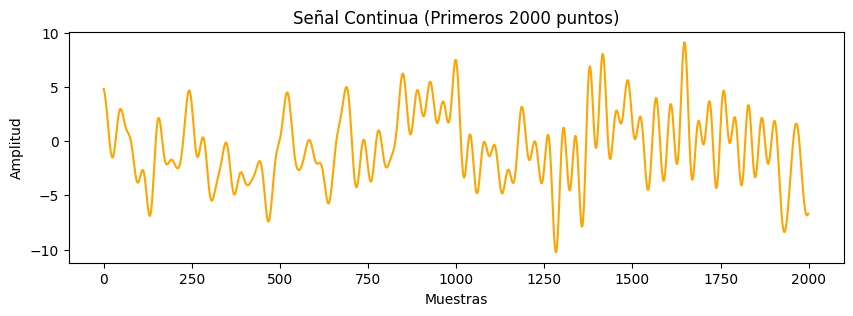

In [ ]:
# Asumimos que senal_continua es una variable previamente definida
# Imprimir las dimensiones de los datos cargados
print("Dimensiones de los datos cargados: " + str(senal_continua.shape))

# Crear una figura para el gráfico
fig = plt.figure(figsize=(10, 3))

# Graficar las primeras 2000 muestras de la señal continua (asumiendo que es una matriz)
plt.plot(senal_continua[0, 0:2000], color='orange')  # Seleccionando la primera fila (canal 0)
plt.title("Señal Continua (Primeros 2000 puntos)")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.savefig("senal_continua.png", dpi=300)
# Mostrar el gráfico
plt.show()

**Comparación estadística de Energía de señales EEG**

---



In [ ]:
def energiapromedio(signal):  # Recibe una señal con la forma: (Canales, muestras, épocas)
    energia_epoca = np.sum(np.square(signal), axis=1)  # Energía por época
    energia_promedio = np.mean(energia_epoca, axis=1)  # Promedio por canal
    return energia_promedio

num_canales = 8
co_pk = ['control', 'parkinson']

# Ruta al directorio
directorio_actual = os.getcwd()
base_directory = os.path.join(directorio_actual, "drive", "MyDrive", "Bioseñales", "datos_senales_datos_parkinson_cursos")

# Obtener los archivos de sujetos control
archivos = os.listdir(os.path.join(base_directory, co_pk[0]))
print(f"Número de sujetos: {len(archivos)}")

# Seleccionar un sujeto
indice_sujeto = 1 # Cambia este número para otro sujeto
archivo_sujeto = archivos[indice_sujeto]
ruta_sujeto = os.path.join(base_directory, co_pk[0], archivo_sujeto)

# Cargar datos
data = sio.loadmat(ruta_sujeto)["data"]
print(f"Shape de los datos: {data.shape}")

# Calcular energía promedio por canal
energia = energiapromedio(data)

# Crear un DataFrame para mostrar y exportar
df_energia = pd.DataFrame({
    "Canal": [f"Canal {i+1}" for i in range(num_canales)],
    "Energía Promedio": energia
})

# Mostrar la tabla en consola
print(df_energia.to_string(index=False))

# Exportar como archivo LaTeX
nombre_archivo_latex = f"energia_promedio_{co_pk[0]}_sujeto_{indice_sujeto + 1}.tex"
df_energia.to_latex(nombre_archivo_latex, index=False, float_format="%.2f")



Número de sujetos: 36
Shape de los datos: (8, 2000, 176)
  Canal  Energía Promedio
Canal 1         15966.403
Canal 2         17617.810
Canal 3         20804.937
Canal 4         19654.400
Canal 5         16678.982
Canal 6         93894.049
Canal 7         66862.496
Canal 8         75685.126


In [ ]:
# Directorio base
directorio_actual = os.getcwd()
base_directory = os.path.join(directorio_actual, "drive", "MyDrive", "Bioseñales", "datos_senales_datos_parkinson_cursos")

num_canales = 8
co_pk = ['control', 'parkinson']

# DataFrames para guardar resultados
df_control = pd.DataFrame(columns=[f"Canal_{i+1}" for i in range(num_canales)])
df_parkinson = pd.DataFrame(columns=[f"Canal_{i+1}" for i in range(num_canales)])

# Iterar sobre ambos grupos
for grupo in co_pk:
    archivos = os.listdir(os.path.join(base_directory, grupo))

    for i, archivo in enumerate(sorted(archivos)):
        ruta_archivo = os.path.join(base_directory, grupo, archivo)
        data = sio.loadmat(ruta_archivo)["data"]

        energia_prom = energiapromedio(data)

        nombre_fila = f"Sujeto {i+1}"
        if grupo == 'control':
            df_control.loc[nombre_fila] = energia_prom
        else:
            df_parkinson.loc[nombre_fila] = energia_prom

# Mostrar los DataFrames con formato de tabla
print("\nENERGÍA PROMEDIO POR CANAL - GRUPO CONTROL")
display(df_control)

print("\nENERGÍA PROMEDIO POR CANAL - GRUPO PARKINSON")
display(df_parkinson)



ENERGÍA PROMEDIO POR CANAL - GRUPO CONTROL


,Canal_1,Canal_2,Canal_3,Canal_4,Canal_5,Canal_6,Canal_7,Canal_8
Sujeto 1,21465.650,20985.908,22760.150,18505.640,29730.163,25244.158,22781.328,24658.600
Sujeto 2,15966.403,17617.810,20804.937,19654.400,16678.982,93894.049,66862.496,75685.126
Sujeto 3,14148.673,18284.000,28749.932,14270.727,28787.446,14661.418,15940.154,19499.899
Sujeto 4,35311.302,34916.686,38800.429,35427.031,35905.473,106598.128,106885.576,112520.751
Sujeto 5,18510.830,19738.489,20911.793,21828.254,23351.993,53086.060,37495.972,43067.096
Sujeto 6,13180.109,13925.218,16218.994,12324.884,14060.301,25767.025,21935.760,22827.781
Sujeto 7,11197.555,10948.369,12737.005,10745.162,10329.642,21461.606,15493.213,27414.375
Sujeto 8,28551.124,26204.839,17383.999,17244.606,26206.372,83370.618,51121.106,67852.348
Sujeto 9,9133.036,9214.155,11626.412,10809.622,10467.880,46336.874,45695.802,50086.362
Sujeto 10,47166.557,55107.799,52286.885,34682.657,30606.119,227045.733,224891.029,322172.432



ENERGÍA PROMEDIO POR CANAL - GRUPO PARKINSON


,Canal_1,Canal_2,Canal_3,Canal_4,Canal_5,Canal_6,Canal_7,Canal_8
Sujeto 1,12438.244,11261.176,10819.635,9489.784,12091.061,22798.213,23700.620,25606.065
Sujeto 2,17995.660,12001.602,12286.344,14785.908,17058.433,63983.449,53715.461,66403.639
Sujeto 3,38092.103,43575.379,41979.995,41715.288,46513.737,251649.395,179345.438,262361.180
Sujeto 4,23742.326,22070.008,24540.316,21803.936,22594.340,128314.265,128888.486,152799.284
Sujeto 5,48574.519,51806.530,73171.952,59707.700,56552.176,287105.762,222745.793,353312.298
Sujeto 6,16202.417,13124.248,13988.674,12752.027,15784.724,50730.233,50742.238,73694.062
Sujeto 7,10692.948,10841.187,12154.390,24161.685,14789.174,43302.826,42560.942,39043.973
Sujeto 8,12157.230,13398.659,17668.878,14841.105,11297.742,38701.648,41828.974,61328.611
Sujeto 9,9581.810,14008.573,9589.230,9374.086,8154.942,28970.849,40705.897,36624.859
Sujeto 10,23658.739,23990.256,30633.746,22888.894,19932.316,65161.432,60552.835,58441.049


In [ ]:
# Guardar DataFrame de control
df_control.to_latex("tabla_control.tex", index=True, float_format="%.2f")

# Guardar DataFrame de parkinson
df_parkinson.to_latex("tabla_parkinson.tex", index=True, float_format="%.2f")


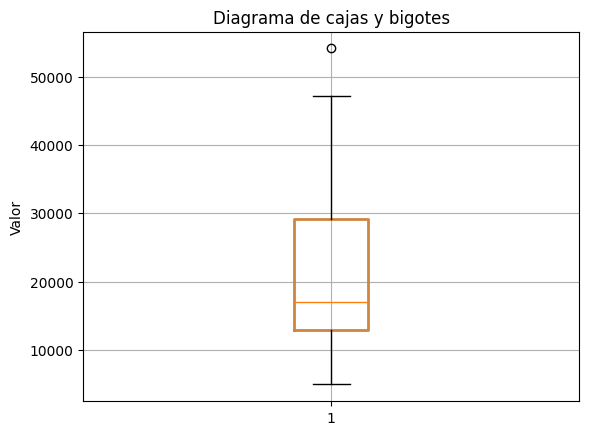

In [ ]:
# Crear boxplot
canal_1_control = df_control['Canal_1']
boxprops = dict(linestyle='-', linewidth=2, color='peru')
plt.boxplot(canal_1_control,boxprops=boxprops)
plt.title('Diagrama de cajas y bigotes')
plt.ylabel('Valor')
plt.grid(True)
plt.show()


**Normalidad, Hipótesis:**

p > alpha

*   H0: Los datos parecen normales (No se puede rechazar H0)
*   H1: Los datos no parecen normales (Se rechaza H0)

In [ ]:
# Lista de los canales
canal_control = ['Canal_1', 'Canal_2', 'Canal_3', 'Canal_4', 'Canal_5', 'Canal_6', 'Canal_7', 'Canal_8']

# Lista para almacenar los resultados
resultados = []

# Prueba K-S y guardar resultados
for canal in canal_control:
    canal_n_control = df_control[canal]
    ks_stats, p_value = kstest(canal_n_control, 'norm')

    decision = 'No se rechaza H0' if p_value > 0.05 else 'Se rechaza H0'
    resultados.append([canal, p_value, decision])

# Crear DataFrame con los resultados
df_resultados = pd.DataFrame(resultados, columns=['Canal', 'p-value', 'Decisión'])

# Imprimir tabla
print(df_resultados.to_string(index=False))

# Guardar en archivo .tex
df_resultados.to_latex("resultados_control.tex", index=False, float_format="%.4f")


  Canal  p-value      Decisión
Canal_1      0.0 Se rechaza H0
Canal_2      0.0 Se rechaza H0
Canal_3      0.0 Se rechaza H0
Canal_4      0.0 Se rechaza H0
Canal_5      0.0 Se rechaza H0
Canal_6      0.0 Se rechaza H0
Canal_7      0.0 Se rechaza H0
Canal_8      0.0 Se rechaza H0


In [ ]:
# Lista de los canales
canal_parkinson = ['Canal_1', 'Canal_2', 'Canal_3', 'Canal_4', 'Canal_5', 'Canal_6', 'Canal_7', 'Canal_8']

# Lista para guardar resultados
resultados_parkinson = []

# Prueba K-S para cada canal
for canal in canal_parkinson:
    canal_n_parkinson = df_parkinson[canal]
    ks_stats, p_value = kstest(canal_n_parkinson, 'norm')
    decision = 'No se rechaza H0' if p_value > 0.05 else 'Se rechaza H0'
    resultados_parkinson.append([canal, p_value, decision])

# Crear DataFrame con los resultados
df_resultados_parkinson = pd.DataFrame(resultados_parkinson, columns=['Canal', 'p-value', 'Decisión'])

# Imprimir tabla
print(df_resultados_parkinson.to_string(index=False))

# Guardar en archivo .tex
df_resultados_parkinson.to_latex("resultados_parkinson.tex", index=False, float_format="%.4f")


  Canal  p-value      Decisión
Canal_1      0.0 Se rechaza H0
Canal_2      0.0 Se rechaza H0
Canal_3      0.0 Se rechaza H0
Canal_4      0.0 Se rechaza H0
Canal_5      0.0 Se rechaza H0
Canal_6      0.0 Se rechaza H0
Canal_7      0.0 Se rechaza H0
Canal_8      0.0 Se rechaza H0


**Homocedasticidad:**

Prueba de Levene

**Hipótesis:**

*   H0: Los grupos tienen varianzas iguales
*   H1: Los grupos tienen varianzas diferentes

In [ ]:
# Lista para almacenar los resultados
resultados_levene = []

# Prueba de Levene canal por canal
for canal in range(8):
    canal_nombre = f"Canal_{canal+1}"
    canal_h_control = df_control[canal_control[canal]]
    canal_h_parkinson = df_parkinson[canal_parkinson[canal]]

    stat_levene, p_levene = levene(canal_h_control, canal_h_parkinson)
    decision = 'No se rechaza H0' if p_levene > 0.05 else 'Se rechaza H0'
    resultados_levene.append([canal_nombre, p_levene, decision])

# Crear DataFrame
df_resultados_levene = pd.DataFrame(resultados_levene, columns=['Canal', 'p-value', 'Decisión'])

# Mostrar la tabla
print(df_resultados_levene.to_string(index=False))

# Guardar como archivo .tex
df_resultados_levene.to_latex("resultados_levene.tex", index=False, float_format="%.4f")

  Canal  p-value         Decisión
Canal_1    0.885 No se rechaza H0
Canal_2    0.959 No se rechaza H0
Canal_3    0.978 No se rechaza H0
Canal_4    0.759 No se rechaza H0
Canal_5    0.905 No se rechaza H0
Canal_6    0.472 No se rechaza H0
Canal_7    0.618 No se rechaza H0
Canal_8    0.594 No se rechaza H0


**U Mann-Whitney-Wilcoxon**

* HO: No hay diferencia (en términos de tendencia central) entre los dos grupos de la población.
* H1: Existe una diferencia (con respecto a la tendencia central) entre los dos grupos de la población.

Las condiciones del u-test son:

* Los datos tienen que ser independientes.

* Los datos tienen que ser ordinales.

* No es necesario asumir que las muestras se distribuyen de forma normal.

* Igualdad de varianza entre grupos (homocedasticidad).

In [ ]:
# Lista para almacenar resultados
resultados_mann = []

# Ejecutar prueba por canal
for canal in range(8):
    canal_nombre = f"Canal_{canal+1}"
    canal_h_control = df_control[canal_control[canal]]
    canal_h_parkinson = df_parkinson[canal_parkinson[canal]]

    stat_mann, p_mann = mannwhitneyu(canal_h_control, canal_h_parkinson)
    decision = 'No se rechaza H0' if p_mann > 0.05 else 'Se rechaza H0'
    resultados_mann.append([canal_nombre, p_mann, decision])

# Crear DataFrame
df_resultados_mann = pd.DataFrame(resultados_mann, columns=['Canal', 'p-value', 'Decisión'])

# Mostrar como tabla
print(df_resultados_mann.to_string(index=False))

# Guardar en archivo .tex
df_resultados_mann.to_latex("resultados_mannwhitney.tex", index=False, float_format="%.4f")

  Canal  p-value         Decisión
Canal_1    0.406 No se rechaza H0
Canal_2    0.571 No se rechaza H0
Canal_3    0.460 No se rechaza H0
Canal_4    0.234 No se rechaza H0
Canal_5    0.560 No se rechaza H0
Canal_6    0.280 No se rechaza H0
Canal_7    0.118 No se rechaza H0
Canal_8    0.151 No se rechaza H0
